# Prediction of protein subcellular localisation - Jorge Martínez (M2BI)

## Load modules

In [27]:
import numpy as np
from pandas import read_csv
from sklearn import preprocessing

# Tensorflow and keras import
from keras import layers, models, utils, callbacks, optimizers

# # Utils to manipulate data
from keras.utils import to_categorical

# # Keras models
from keras.models import Sequential

# # Keras layers
from keras.layers import Dense, Dropout
from keras.layers import TimeDistributed
from keras.layers import add
from keras.layers import Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten


# # Callback (for learning/optimize)
from keras.callbacks  import TensorBoard
from scikeras import wrappers
from scikeras.wrappers import KerasClassifier


# # Data analysis and protocol
from sklearn.model_selection     import cross_val_score
from sklearn.model_selection     import train_test_split
from sklearn.model_selection     import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# # Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and take a first look

In [44]:
# Load the data
train = np.load("../data/reduced_train.npz")
test = np.load("../data/reduced_val.npz")

# Create the x and y data for the train and test sets
x_train = train['X_train']
y_train = train['y_train']

x_test = test['X_val']
y_test = test['y_val']

# Basic Information
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

# Data Types
print("\nData types:")
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Missing Values
print("\nMissing values in x_train:", np.isnan(x_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

Shape of x_train: (2423, 400, 20)
Shape of y_train: (2423,)
Shape of x_test: (635, 400, 20)
Shape of y_test: (635,)

Data types:
x_train dtype: float32
y_train dtype: int32

Missing values in x_train: 0
Missing values in y_train: 0


In [45]:
# Sample Data
print("\nFirst 5 rows of x_train:")
print(x_train[:5])
print("\nFirst 5 rows of y_train:")
print(y_train[:5])


First 5 rows of x_train:
[[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0. 


Class distribution in y_train:
Class 0: 338 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 233 samples
Class 4: 285 samples
Class 5: 63 samples
Class 6: 224 samples
Class 7: 59 samples
Class 8: 60 samples
Class 9: 59 samples


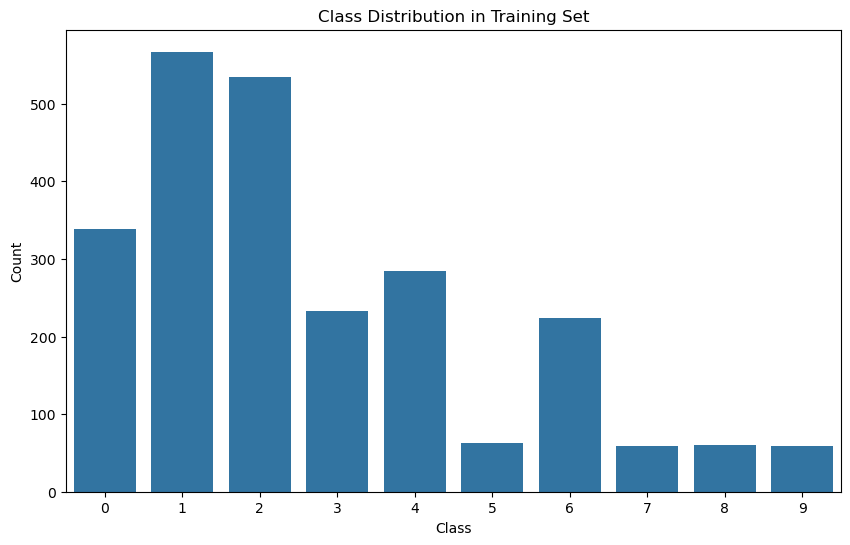

In [46]:
# Class Distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in y_train:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")
    
# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [47]:
# One hot encoding
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## CNN

In [49]:
def cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=64, 
                     kernel_size=3, 
                     activation='relu', 
                     input_shape=(400, 20)))
    model.add(Conv1D(filters=64, 
                     kernel_size=3, 
                     activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

model1 = cnn_model()
model1.summary()

/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 398, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 396, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 396, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 198, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │     1,267,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,284,566 (4.90 MB)

 Trainable params: 1,284,566 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
callback = callbacks.EarlyStopping(monitor = 'val_weighted_accuracy',
                                patience = 5,
                                mode = 'max')   
history = model1.fit(
    x_train, y_train,
    batch_size = 32,
    epochs = 10,
    validation_split=0.2,
    callbacks= callbacks.EarlyStopping(monitor = 'val_weighted_accuracy',
                                   patience = 5,
                                   mode = 'max'))

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3194 - loss: 1.9203 - val_accuracy: 0.5052 - val_loss: 1.5374
Epoch 2/10
11/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7177 - loss: 0.9664

/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_weighted_accuracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7026 - loss: 0.9808 - val_accuracy: 0.6660 - val_loss: 1.0909
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8353 - loss: 0.5328 - val_accuracy: 0.7175 - val_loss: 0.9369
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9225 - loss: 0.3108 - val_accuracy: 0.7072 - val_loss: 0.9856
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9498 - loss: 0.1794 - val_accuracy: 0.7340 - val_loss: 0.8546
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9686 - loss: 0.1218 - val_accuracy: 0.7361 - val_loss: 0.9091
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9925 - loss: 0.0559 - val_accuracy: 0.7608 - val_loss: 0.9341
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9943 - loss: 0.0379 - val_accuracy: 0.7485 - val_loss: 1.0262
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9975 - loss: 0.0333 - val_accuracy: 0.7670 - val_loss: 0.